# Compare the motifs (the CWMs and hCWMs) and motif instance calls between CUT&RUN and ChIP-seq
## How do the motif instance calls differ? Compare the distribution of the motif instance calls and see if there's a difference that can be explained by:
* Overlap with DNase-seq peaks
* Overlap with ATAC-seq peaks
* Correlation with ATAC-seq fragment lengths
* Overlap with H3K27ac or H3K4me3 (histone marks)

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

plt.rcParams['figure.dpi'] = 130

/tmp/ipykernel_107051/1313173272.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

In [4]:
# FOSL2 cutnrun and chip-seq motif hits

# Define parameters/fetch arguments
motif_hits_path_cutnrun = ['/home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_cutnrun_feb7/tfm_matches.bed']
print("CUT&RUN Motif hits path: %s" % motif_hits_path_cutnrun)

motif_hits_path_chipseq = ['/home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_chipseq_feb7/tfm_matches.bed']
print("chipseq Motif hits path: %s" % motif_hits_path_chipseq)

CUT&RUN Motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_cutnrun_feb7/tfm_matches.bed']
chipseq Motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_chipseq_feb7/tfm_matches.bed']


In [5]:
# Load in assay peaks
assay_bed_paths = ['/home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz']
print("ATAC peaks path: %s" % assay_bed_paths[0])
print("DNASE peaks path: %s" % assay_bed_paths[1])
print("ac histone marks: %s" % assay_bed_paths[2])
print("me3 histone marks: %s" % assay_bed_paths[3])

ATAC peaks path: /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz
DNASE peaks path: /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz
ac histone marks: /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz
me3 histone marks: /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz


In [6]:
# Import motif hits
hits_cutnrun = import_peak_table(motif_hits_path_cutnrun)          # 155,990 hits and peak lengths are 9
hits_chipseq = import_peak_table(motif_hits_path_chipseq)          # 91,338 hits and peak lengths are 9, 19, or 25

# Isolate to core motif
core_hits_cutnrun = hits_cutnrun[hits_cutnrun.name == '0_0']           # 109,727 hits and peak lengths are 9 
core_hits_chipseq = hits_chipseq[hits_chipseq.name == '0_0']           # 90,918 hits and peak lengths are 9 only

# Import assay peaks
atac_peak_table = import_peak_table([assay_bed_paths[0]])  # 278,564 peaks and TONS of peak lengths
dnase_peak_table = import_peak_table([assay_bed_paths[1]]) # 143,283 peaks and TONS of peak lengths
ac_peak_table = import_peak_table([assay_bed_paths[2]])    # 129,753 peaks and TONS of peak lengths
me3_peak_table = import_peak_table([assay_bed_paths[3]])   # 27,884 peaks and TONS of peak lengths

### DNase-seq overlap

In [16]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_cutnrun_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/cutnrun_motif_hits_dnase_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_chipseq_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/chipseq_motif_hits_dnase_overlap')

cutnrun_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/cutnrun_motif_hits_dnase_overlap',  # 97,042 overlaps
                                sep='\t', header=None)
chipseq_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/chipseq_motif_hits_dnase_overlap',  # 55,528 overlaps
                                sep='\t', header=None)

In [17]:
core_cutnrun_dnase_overlap = cutnrun_dnase_overlap[cutnrun_dnase_overlap.iloc[:,3] == '0_0']                # 68,363 core overlaps
core_chipseq_dnase_overlap = chipseq_dnase_overlap[chipseq_dnase_overlap.iloc[:,3] == '0_0']                # 55,237 core overlaps

In [18]:
len(core_cutnrun_dnase_overlap) / len(core_hits_cutnrun)  # % of cutnrun task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF
# and i did check, core_cutnrun_dnase_overlap is a SUBSET of the original df, core_hits_cutnrun (check using merge function)

0.6230280605502748

In [19]:
len(core_chipseq_dnase_overlap) / len(core_hits_chipseq)  # % of chipseq task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.6075474603488858

### ATAC-seq overlap

In [25]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_cutnrun_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/cutnrun_motif_hits_atac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_chipseq_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/chipseq_motif_hits_atac_overlap')

cutnrun_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/cutnrun_motif_hits_atac_overlap',  # 124,368 overlaps
                                sep='\t', header=None)
chipseq_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/chipseq_motif_hits_atac_overlap',  # 76,135 overlaps
                                sep='\t', header=None)

In [28]:
core_cutnrun_atac_overlap = cutnrun_atac_overlap[cutnrun_atac_overlap.iloc[:,3] == '0_0']                # 84,692 core overlaps
core_chipseq_atac_overlap = chipseq_atac_overlap[chipseq_atac_overlap.iloc[:,3] == '0_0']                # 75,769 core overlaps

In [29]:
len(core_cutnrun_atac_overlap) / len(core_hits_cutnrun)  # % of cutnrun task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.7718428463368178

In [30]:
len(core_chipseq_atac_overlap) / len(core_hits_chipseq)  # % of chipseq task hits overlatacg >0 DNase peak ONLY FOR CORE MOTIF

0.8333773290217559

#### ATAC-seq fragment length correlation

In [ ]:
# TODO

### H3K27ac overlap

In [34]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_cutnrun_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/cutnrun_motif_hits_h3k27ac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_chipseq_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/chipseq_motif_hits_h3k27ac_overlap')

cutnrun_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/cutnrun_motif_hits_h3k27ac_overlap',  # 94,209 overlaps
                                sep='\t', header=None)
chipseq_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/chipseq_motif_hits_h3k27ac_overlap',  # 61,455 overlaps
                                sep='\t', header=None)

In [36]:
core_cutnrun_ac_overlap = cutnrun_ac_overlap[cutnrun_ac_overlap.iloc[:,3] == '0_0']                # 62,135 core overlaps
core_chipseq_ac_overlap = chipseq_ac_overlap[chipseq_ac_overlap.iloc[:,3] == '0_0']                # 61,172 core overlaps

In [38]:
len(core_cutnrun_ac_overlap) / len(core_hits_cutnrun)  # % of cutnrun task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.5662690130961386

In [39]:
len(core_chipseq_ac_overlap) / len(core_hits_chipseq)  # % of chipseq task hits overlatacg >0 DNase peak ONLY FOR CORE MOTIF

0.6728260630458215

### H3K4me3 overlap

In [43]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_cutnrun_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/cutnrun_motif_hits_h3k4me3_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/FOSL2/fosl2_chipseq_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/chipseq_motif_hits_h3k4me3_overlap')

cutnrun_me_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/cutnrun_motif_hits_h3k4me3_overlap',  # 26,132 overlaps
                                sep='\t', header=None)
chipseq_me_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/FOSL2/chipseq_motif_hits_h3k4me3_overlap',  # 9,776 overlaps
                                sep='\t', header=None)

In [47]:
core_cutnrun_me_overlap = cutnrun_me_overlap[cutnrun_me_overlap.iloc[:,3] == '0_0']                # 11,635 core overlaps
core_chipseq_me_overlap = chipseq_me_overlap[chipseq_me_overlap.iloc[:,3] == '0_0']                # 9,732 core overlaps

In [48]:
len(core_cutnrun_me_overlap) / len(core_hits_cutnrun)  # % of cutnrun task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.10603588907014681

In [49]:
len(core_chipseq_me_overlap) / len(core_hits_chipseq)  # % of chipseq task hits overlatacg >0 DNase peak ONLY FOR CORE MOTIF

0.10704150993202666

## Graphing

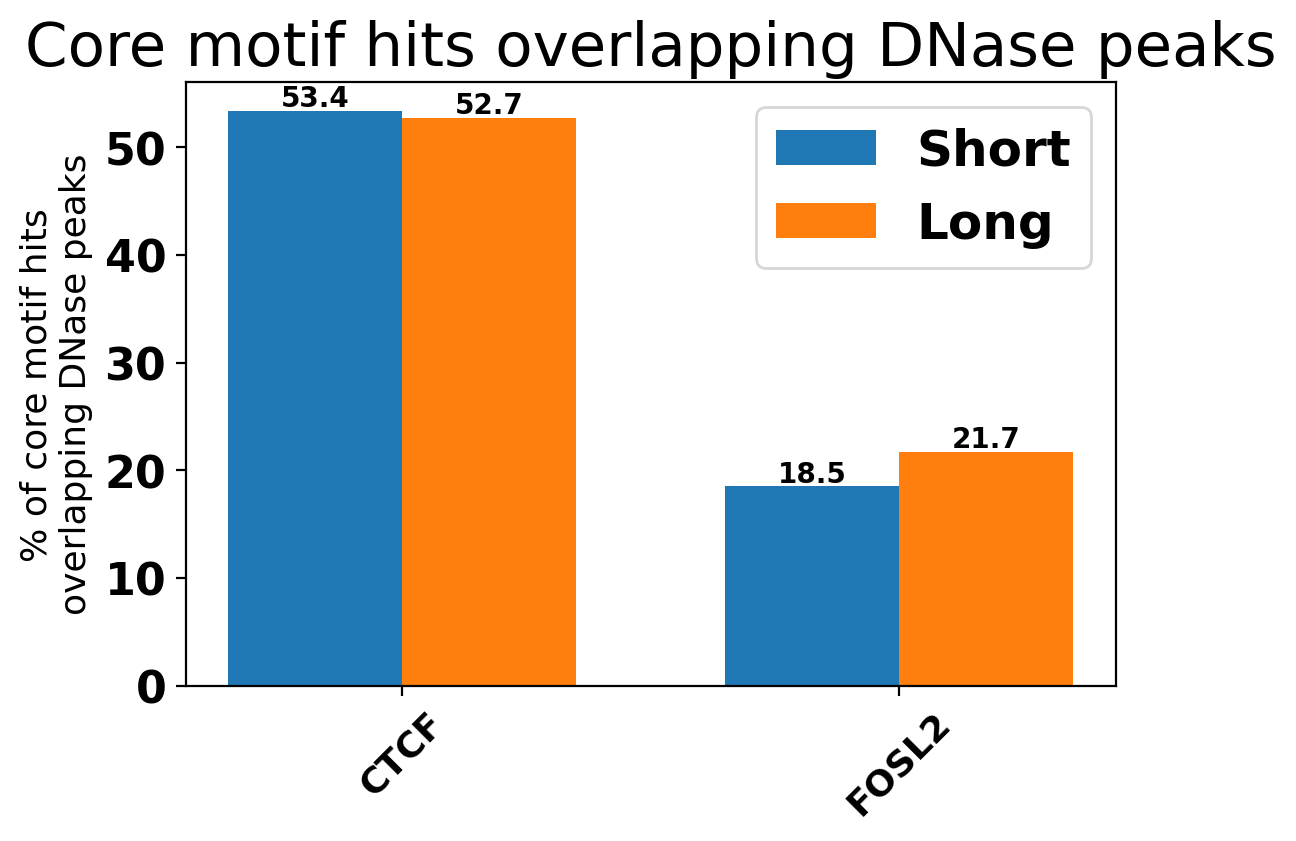

In [113]:
# order: ( % of CUT&RUN motif hits from ctcf, fosl2 with key 0_0 overlapping a dnase peak, 
#          % of chipseq motif hits from ctcf, fosl2 with key 0_0 overlapping a dnase peak)
ctcf_stats = (53.4, 18.5)
fosl2_stats = (52.7, 21.7)

ind = np.arange(len(ctcf_stats))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=200)
rects1 = ax.bar(ind - width/2, ctcf_stats, width, 
                label='CUT&RUN')
rects2 = ax.bar(ind + width/2, fosl2_stats, width,
                label='chipseq')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of core motif hits\noverlapping DNase peaks', fontsize=13)
ax.set_title('Core motif hits overlapping DNase peaks')
ax.set_xticks(ind)
ax.set_xticklabels(('CTCF', 'FOSL2'), rotation=45, fontsize=13)
ax.legend(loc='upper right')

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, -0.5),  # use -0.5 point offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")

plt.show()